#2. Mechanistic Interepretability


##  Layer Conductance

Bir ağın $L$ katmanındaki $j$ nöronunun iletkenliği şu şekilde tanımlanır:

$$
= \int_{\alpha=0}^{1}
\frac{\partial F(x' + \alpha(x - x'))}{\partial \gamma_y(\alpha)}
\cdot
\frac{\partial \gamma_y(\alpha)}{\partial \alpha}
\, d\alpha
$$

Açıklamalar:

- $ \int_{\alpha=0}^{1} $ : İntegral, $\alpha = 0$ ile $\alpha = 1$ aralığında alınır. Bu, giriş uzayında $x'$ (baseline) ile $x$ (gerçek giriş) arasında çizilen interpolasyon yoludur.

- $ x' + \alpha(x - x') $ : $x'$ ile $x$ arasında doğrusal bir yol tanımlar. $\alpha$ bu yol boyunca ilerlemeyi kontrol eder. $\alpha = 0$ için $x'$, $\alpha = 1$ için $x$ elde edilir.

- $ \frac{\partial F(x' + \alpha(x - x'))}{\partial \gamma_y(\alpha)} $ : Model çıktısı olan $F$ fonksiyonunun, ara katmandaki aktivasyon $\gamma_y(\alpha)$'ya göre kısmi türevidir. Yani: "Ara katmandaki küçük bir değişiklik, çıktıyı ne kadar etkiler?"

- $ \frac{\partial \gamma_y(\alpha)}{\partial \alpha} $ : Ara katman aktivasyonlarının, interpolasyon parametresi $\alpha$'ya göre türevidir. Bu da: "Yol boyunca gidildikçe iç aktivasyonlar nasıl değişiyor?" sorusunu yanıtlar.

- Bu ifade, **zincir kuralı** (chain rule) ile elde edilmiştir ve **Integrated Gradients** yöntemi gibi gradyan tabanlı açıklanabilirlik metotlarının temelini oluşturur.



###Interpolasyon Nedir
Gerçek giriş (tokenlar):

$$
x = \text{Embedding}(\text{["The", "capital", "of", "France", "is"]})
$$

Referans giriş:

$$
x' = \text{Embedding}(\text{["[PAD]", "[PAD]", "[PAD]", "[PAD]", "[PAD]"]}) \quad \text{veya} \quad \vec{0}
$$

Interpolasyon boyunca:

$$
x^{(\alpha)} = x' + \alpha (x - x') \quad \text{ile} \quad \alpha \in [0, 1]
$$

Bu interpolasyonla, modelin çıktısı (örneğin `"Paris"` logiti) üzerindeki etkileri hesaplayarak, hangi kelimelerin çıktıya ne kadar katkı sağladığı analiz edilir.


##2.1 Uygulama

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from captum.attr import LayerConductance,InternalInfluence
import torch

model_name = "meta-llama/Llama-3.2-3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32)
model.eval()

prompt = "The capital of Turkey is"
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]

with torch.no_grad():
    input_embeds = model.model.embed_tokens(input_ids)

input_embeds.requires_grad_(True)

target_token = " Ankara"
target_token_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(target_token))[0]

def forward_func(input_embeds):
    outputs = model(inputs_embeds=input_embeds)
    logits = outputs.logits
    return logits[:, -1, target_token_id]

target_layer = model.model.layers[10].mlp.down_proj

layer_cond = LayerConductance(forward_func, target_layer)
attributions = layer_cond.attribute(inputs=input_embeds)

total_score = attributions.sum().item()
print(f"Total Layer Conductance to predicting '{target_token.strip()}': {total_score:.4f}")



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Total Layer Conductance to predicting 'Ankara': 0.2312


In [ ]:

scores=[]
for i in range(10,20):
  target_layer = model.model.layers[i].mlp.down_proj

  layer_cond = LayerConductance(forward_func, target_layer)
  attributions = layer_cond.attribute(inputs=input_embeds)
  total_score = attributions.sum().item()
  scores.append(total_score)
  print(f"Total Layer Internal Influence to predicting '{target_token.strip()}' oflayer {i}: {total_score:.4f}")


Total Layer Contribution to predicting 'Ankara' oflayer 10: 0.2312
Total Layer Contribution to predicting 'Ankara' oflayer 11: 5.1074
Total Layer Contribution to predicting 'Ankara' oflayer 12: -0.8519
Total Layer Contribution to predicting 'Ankara' oflayer 13: 3.2039
Total Layer Contribution to predicting 'Ankara' oflayer 14: 4.6885
Total Layer Contribution to predicting 'Ankara' oflayer 15: 7.0019
Total Layer Contribution to predicting 'Ankara' oflayer 16: 5.0307
Total Layer Contribution to predicting 'Ankara' oflayer 17: 6.3934
Total Layer Contribution to predicting 'Ankara' oflayer 18: 4.5808
Total Layer Contribution to predicting 'Ankara' oflayer 19: 4.4671


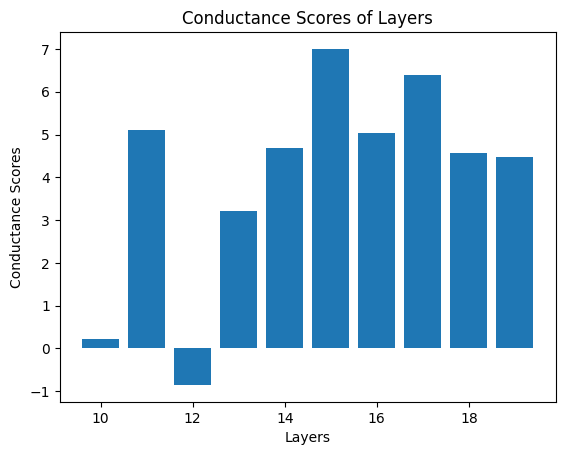

In [ ]:
import matplotlib.pyplot as plt
layers=list(range(10,20))
plt.bar(layers,scores)
plt.xlabel('Layers')
plt.ylabel('Conductance Scores')
plt.title('Conductance Scores of Layers')
plt.show()


##Internal Influence

$$
\text{Influence}_j = (x_j - x'_j) \cdot \int_{0}^{1} \frac{\partial F(x(\alpha))}{\partial x_j} \, d\alpha
$$

**Açıklamalar:**

- $x_j$: Hedef katmandaki $j$. nöronun aktivasyonu (gerçek girdi $x$ için hesaplanmış).
- $x'_j$: Aynı nöronun **baseline girdi** (genellikle sıfır vektörü) için aktivasyonu.
- $x(\alpha)$: $x' + \alpha(x - x')$ interpolasyonuyla elde edilen katman aktivasyonu. $\alpha \in [0, 1]$ arasında değişir.
- $F(x(\alpha))$: Modelin çıktısı; interpolasyon yolundaki aktivasyonlara karşılık gelen çıktı değeri.
- $\frac{\partial F(x(\alpha))}{\partial x_j}$: $j$. nöronun aktivasyonu değiştiğinde model çıktısının ne kadar değiştiğini gösteren gradyan (duyarlılık).
- $\int_0^1 \cdots d\alpha$: $\alpha$ ile 0'dan 1'e kadar yapılan entegrasyon; yani tüm yol boyunca katkının toplanması.

Computes internal influence by approximating the integral of gradients for a particular layer along the path from a baseline input to the given input. If no baseline is provided, the default baseline is the zero tensor. More details on this approach can be found here: https://arxiv.org/abs/1802.03788

Note that this method is similar to applying integrated gradients and taking the layer as input, integrating the gradient of the layer with respect to the output


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from captum.attr import LayerConductance,InternalInfluence
import torch

model_name = "meta-llama/Llama-3.2-3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32)
model.eval()

prompt = "The capital of Turkey is"
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]

with torch.no_grad():
    input_embeds = model.model.embed_tokens(input_ids)

input_embeds.requires_grad_(True)

target_token = " Ankara"
target_token_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(target_token))[0]

def forward_func(input_embeds):
    outputs = model(inputs_embeds=input_embeds)
    logits = outputs.logits
    return logits[:, -1, target_token_id]

target_layer = model.model.layers[10].mlp.down_proj

layer_cond = InternalInfluence(forward_func, target_layer)
attributions = layer_cond.attribute(inputs=input_embeds)

total_score = attributions.sum().item()
print(f"Total Layer InternalInfluence to predicting '{target_token.strip()}': {total_score:.4f}")



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Total Layer InternalInfluence to predicting 'Ankara': 11.9117


In [ ]:
scores=[]
for i in range(10,20):
  target_layer = model.model.layers[i].mlp.down_proj

  layer_cond = InternalInfluence(forward_func, target_layer)
  attributions = layer_cond.attribute(inputs=input_embeds)
  total_score = attributions.sum().item()
  scores.append(total_score)
  print(f"Total Layer Internal Influence to predicting '{target_token.strip()}' oflayer {i}: {total_score:.4f}")

Total Layer Internal Influence to predicting 'Ankara' oflayer 10: 11.9117
Total Layer Internal Influence to predicting 'Ankara' oflayer 11: 9.9853
Total Layer Internal Influence to predicting 'Ankara' oflayer 12: 7.9536
Total Layer Internal Influence to predicting 'Ankara' oflayer 13: 6.6808
Total Layer Internal Influence to predicting 'Ankara' oflayer 14: 3.9165
Total Layer Internal Influence to predicting 'Ankara' oflayer 15: 1.5760
Total Layer Internal Influence to predicting 'Ankara' oflayer 16: -2.4217
Total Layer Internal Influence to predicting 'Ankara' oflayer 17: -0.0115
Total Layer Internal Influence to predicting 'Ankara' oflayer 18: -0.9402
Total Layer Internal Influence to predicting 'Ankara' oflayer 19: 0.7483


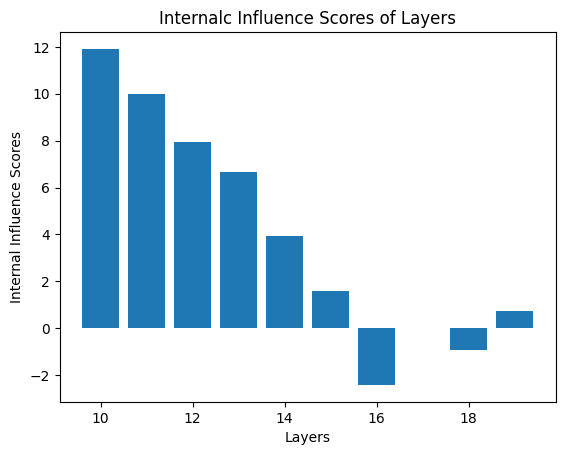

In [ ]:
import matplotlib.pyplot as plt
layers=list(range(10,20))
plt.bar(layers,scores)
plt.xlabel('Layers')
plt.ylabel('Internal Influence Scores')
plt.title('Internalc Influence Scores of Layers')
plt.show()


# Fact Lookup

Bu analiz, büyük dil modellerinin (LLM) belirli bir bilgiyi — örneğin bir sporcunun yaptığı spor dalını — metin işleme sırasında **hangi katmanlarda temsil ettiğini** bulmak amacıyla yapılır.
https://www.alignmentforum.org/posts/iGuwZTHWb6DFY3sKB/fact-finding-attempting-to-reverse-engineer-factual-recall

---

## 1. Amaç

FLU (Fact Lookup) analizinin temel amacı:
- Modelin iç temsillerinde, belirli bir bilginin (örneğin “Cristiano Ronaldo → football”) **ne zaman** (hangi katmanda) “zihinsel olarak oluştuğunu” tespit etmektir.
- Yani, bu bilgi modelin içinde **hangi katmanlarda taşınmaya başlanıyor ve tanımlı hale geliyor**, bunu gözlemlemek.

---

## 2. Girdi Verisi Hazırlığı

- Girdiler genellikle kısa cümlelerden oluşur ve bir özne içerir (örneğin, ünlü bir sporcu).
- Her girdiye karşılık doğru bir sınıf (etiket) atanır (örneğin, "Cristiano Ronaldo" için "football").

Bu sayede hangi cümlenin hangi sınıfa ait olduğu önceden bilinir ve modelin iç temsillerinde bu sınıfa dair bilgi oluşup oluşmadığı ölçülebilir.

---

## 3. Modelin Yüklenmesi

- FLU analizinde transformer tabanlı bir dil modeli  kullanılır.
- Model “eval” moduna alınarak sadece forward pass yapılır. Geri yayılım gerekmez.

---

## 4. Katmanlara Hook Eklenmesi

- Dil modelleri çok katmanlıdır ve her katman bir önceki çıktıyı işler.
- FLU analizinde, her katmana özel bir gözlemci yerleştirilir. Buna “forward hook” denir.
- Bu hook’lar sayesinde her katmandan çıkan aktivasyonlar özellikle [CLS] token temsili kaydedilir.
- Bu temsiller daha sonra bilgi içerip içermediği bakımından test edilir.

---

## 5. Modelin Çalıştırılması (Forward Pass) ????

- Tüm örnek cümleler modele verilir.
- Her katman çalıştıkça, hook’lar devreye girer ve o katmandan çıkan aktivasyonları (örneğin [CLS] token temsili) kaydeder.
- Böylece her girdi için her katmandan bir aktivasyon vektörü elde edilir.

---

## 6. Aktivasyonlara Göre Sınıflayıcı Eğitme (Probing)

- Her katmandan elde edilen aktivasyonlar, etiketlerle eşleştirilerek basit bir sınıflayıcı (örneğin logistic regression) eğitilir.
- Bu sınıflayıcılar, her katmanın bilgiyi ne kadar iyi temsil ettiğini ölçmek için kullanılır.
- Amaç sınıflandırma başarısı değil, **hangi katmanda bilgi “tahmin edilebilir hale” geliyor** bunu görmektir.

---

## 7. Sonuçların Yorumlanması

- Eğer bir katmanda sınıflandırma doğruluğu bir anda yükseliyorsa, bu katmanda bilgi ortaya çıkıyor demektir.
- Bu yükseliş “bilgi zenginleşmesi” olarak yorumlanır.
- Genellikle ilk katmanlarda doğruluk düşüktür, belirli bir noktada yükselir ve sonra sabitlenir.

---






Fact Lookup'ın jailbreak uygulamasında llmin girdileri zararlı ya da zararsız promptlar olacaktır. Biz de bu promptları zararlı mı zararsız mı şeklinde sınıflandıracak modeller eğiterek aynı incelemeyi yapabilirz.

**Sorular**:

1. Biz bu forma nasıl sokabiliriz, multiple choice bir seçenek mi?
2. Analiz Nasıl Olmalı, (Normal prompt vs jailbreak promptlarının conductance)
4. Analiz yöntemleri için ben conductance'a odaklandım isterseniz https://captum.ai/api/layer.html#layer-activation bu linkten başka yöntemler de bakabiliriz, siz ne önerirsiniz?
5. İlerlemek için modellerin hem normal prompt hem jailbreak promptları arasında en fazla influence farkı olan yerlere bakarız, o layerlara unlearning uygulayabiliriz?
